# Simulation of HPL on Dahu

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
warnings.simplefilter(action='ignore') # removing annoying Pandas warning

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_result(name):
    archive = zipfile.ZipFile(name)
    return pandas.read_csv(io.BytesIO(archive.read('results.csv')))

def read_sim_result(name):
    archive = zipfile.ZipFile(name)
    result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    result['platform'] = get_platform(name)
    result['filename'] = name
    info = get_yaml(name, 'info.yaml')
    installfile = info['installfile']
    result['model'] = installfile[8:10]  # filename of the form 'install_A1.yaml', so we get the 'A1'
    return result

reality_files_bad_cooling = [
    '../hpl/grenoble_2019-10-30_1891433.zip',
]

reality_files = [
    '../hpl/grenoble_2018-10-10_1811810.zip',
    '../hpl/grenoble_2018-10-10_1811847.zip',
]

simulation_dir = 'scaling/1/'
simulation_files = [simulation_dir + f for f in os.listdir(simulation_dir)]
dfsim = pandas.concat([read_sim_result(f) for f in simulation_files])
dfsim['kind'] = 'smpi_execute_benched'
simulation_dir = 'scaling/2/'
simulation_files = [simulation_dir + f for f in os.listdir(simulation_dir)]
tmp = pandas.concat([read_sim_result(f) for f in simulation_files])
tmp['kind'] = 'usleep'
dfsim = pandas.concat([dfsim, tmp])
dfsim['mode'] = 'Simulation'

dfreal = pandas.concat([read_result(f) for f in reality_files])
dfreal['mode'] = 'Reality'
dfreal['kind'] = 'NA'

df = pandas.concat([dfsim, dfreal])
sizes = set(dfsim.matrix_size) & set(dfreal.matrix_size)
df = df[df.matrix_size.isin(sizes)]
df.head()

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,...,sys_time,major_page_fault,minor_page_fault,cpu_utilization,platform,filename,model,kind,mode,residual
0,175000,128,32,32,1,2,2,1,0,8,...,608.52,0.0,1.895664e+08,0.99,dahu.xml,scaling/1/grenoble_2020-09-07_1946997.zip,hp,smpi_execute_benched,Simulation,NaN
0,500000,128,32,32,1,2,2,1,0,8,...,5096.82,0.0,2.356040e+09,0.99,dahu.xml,scaling/1/grenoble_2020-09-07_1946995.zip,hp,smpi_execute_benched,Simulation,NaN
0,75000,128,32,32,1,2,2,1,0,8,...,129.52,0.0,8.853022e+06,1.00,dahu.xml,scaling/1/grenoble_2020-09-07_1946996.zip,hp,smpi_execute_benched,Simulation,NaN
0,300000,128,32,32,1,2,2,1,0,8,...,1939.22,0.0,8.086663e+08,0.99,dahu.xml,scaling/1/grenoble_2020-09-07_1946994.zip,hp,smpi_execute_benched,Simulation,NaN
0,50000,128,32,32,1,2,2,1,0,8,...,80.74,0.0,1.340208e+06,1.00,dahu.xml,scaling/1/grenoble_2020-09-07_1946992.zip,hp,smpi_execute_benched,Simulation,NaN


### Checking the parameters

In [2]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm', 'platform', 'model', 'filename',
                   'simulation', 'slow_nodes', 'kind',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode',
                   'start_timestamp', 'stop_timestamp'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,proc_p,depth,process_per_node,mem_align,proc_q,thread_per_process,block_size,swap,bcast,pfact,rfact
0,32,1,32,8,32,1,128,0,2,1,2


In [3]:
from IPython.display import display, Markdown

platforms = [(get_platform(f), zipfile.ZipFile(f).read(get_platform(f)).decode('ascii')) for f in simulation_files]
platforms = list(set(platforms))
assert(len(platforms)) == 1
for name, plat in platforms:
    display(Markdown('### %s' % name))
    display(Markdown('```xml\n%s\n```' % plat))

### dahu.xml

```xml
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460505;15831:5.716405752533658;33956:12.659099698925065;64000:0.9867951082730274"/>
        <prop id="smpi/lat-factor" value="0:1.2162964660682605;8133:19.230103984475342;15831:18.285606440676755;33956:51.6103738900493;64000:129.24904864615127"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.115437983643232e-07"/>
        <prop id="smpi/test" value="8.090518732515405e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="1-32" speed="1" core="32" bw="12.5GBps" lat="0.05us" loopback_bw="18.348422228142745GBps" loopback_lat="0.0us"/>
    </AS>
</platform>

```

### Checking the patch in the new simulation

In [4]:
patches = set()
for row in dfsim.iterrows():
    filename = row[1].filename
    repos = get_yaml(filename, 'info.yaml')['git_repositories']
    hpl = [repo for repo in repos if repo['path'] == 'hpl-2.2']
    assert len(hpl) == 1
    patches.add(hpl[0]['patch'])
assert len(patches) == 1
display(Markdown('```diff\n%s\n```' % patches.pop()))

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/src/pgesv/HPL_pdgesv.c b/src/pgesv/HPL_pdgesv.c
index af46ee6..c5574c1 100644
--- a/src/pgesv/HPL_pdgesv.c
+++ b/src/pgesv/HPL_pdgesv.c
@@ -94,6 +94,8 @@ void HPL_pdgesv
 /* ..
  * .. Executable Statements ..
  */
+   timestamp_t start = get_timestamp();
+   timestamp_t duration;
    if( A->n <= 0 ) return;

    A->info = 0;
@@ -110,6 +112,8 @@ void HPL_pdgesv
  * Solve upper triangular system
  */
    if( A->info == 0 ) HPL_pdtrsv( GRID, A );
+   duration = get_timestamp() - start;
+   record_measure(__FILE__, __LINE__, "HPL_pdgesv", start, duration, 0, NULL);
 /*
  * End of HPL_pdgesv
  */
diff --git a/src/pgesv/HPL_pdupdateTT.c b/src/pgesv/HPL_pdupdateTT.c
index 57444bc..b990903 100644
--- a/src/pgesv/HPL_pdupdateTT.c
+++ b/src/pgesv/HPL_pdupdateTT.c
@@ -113,6 +113,8 @@ void HPL_pdupdateTT
 /* ..
  * .. Executable Statements ..
  */
+   timestamp_t start_pduptate = get_timestamp();
+   timestamp_t duration;
 #ifdef HPL_DETAILED_TIMING
    HPL_ptimer( HPL_TIMING_UPDATE );
 #endif
@@ -125,18 +127,26 @@ void HPL_pdupdateTT
    {
       if( PBCST != NULL )
       {
+         timestamp_t start_bcast = get_timestamp();
          do { (void) HPL_bcast( PBCST, IFLAG ); }
          while( *IFLAG != HPL_SUCCESS );
+         timestamp_t duration = get_timestamp() - start_bcast;
+         record_measure(__FILE__, __LINE__, "first_bcast", start_bcast, duration, 0, NULL);
       }
 #ifdef HPL_DETAILED_TIMING
       HPL_ptimer( HPL_TIMING_UPDATE );
 #endif
+      duration = get_timestamp() - start_pduptate;
+      record_measure(__FILE__, __LINE__, "HPL_pdupdateTT", start_pduptate, duration, 0, NULL);
       return;
    }
 /*
  * Enable/disable the column panel probing mechanism
  */
+   timestamp_t start_bcast2 = get_timestamp();
    (void) HPL_bcast( PBCST, &test );
+   duration = get_timestamp() - start_bcast2;
+   record_measure(__FILE__, __LINE__, "second_bcast", start_bcast2, duration, 0, NULL);
 /*
  * 1 x Q case
  */
@@ -437,6 +447,8 @@ void HPL_pdupdateTT
 #ifdef HPL_DETAILED_TIMING
    HPL_ptimer( HPL_TIMING_UPDATE );
 #endif
+   duration = get_timestamp() - start_pduptate;
+   record_measure(__FILE__, __LINE__, "HPL_pdupdateTT", start_pduptate, duration, 0, NULL);
 /*
  * End of HPL_pdupdateTT
  */

```

### Comparing the simulation with the real execution

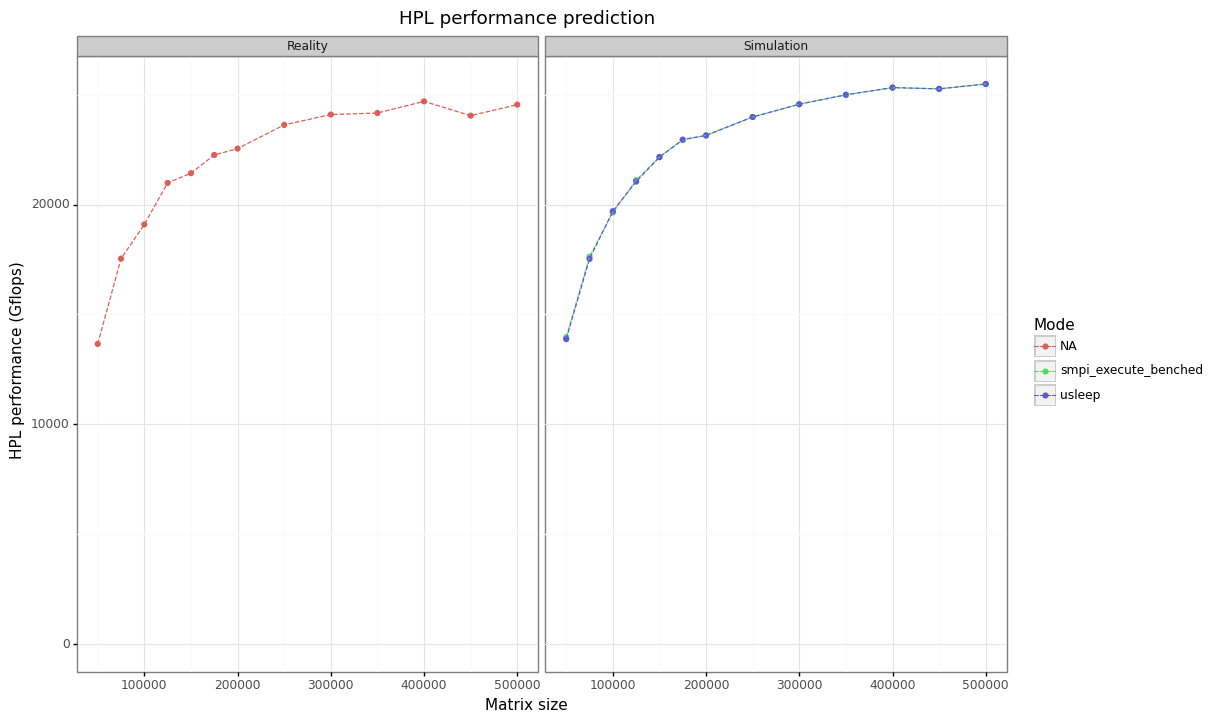

<ggplot: (8770987121693)>

In [5]:
import numpy

(ggplot(df)
    + aes(x='matrix_size', y='gflops', color='kind')
    + theme_bw()
    + expand_limits(y=0)
    + geom_point()
    + stat_summary(fun_y = numpy.mean, geom='line', linetype='dashed')
    + xlab('Matrix size')
    + ylab('HPL performance (Gflops)')
    + labs(color='Mode')
    + facet_wrap('mode')
    + ggtitle('HPL performance prediction')
)

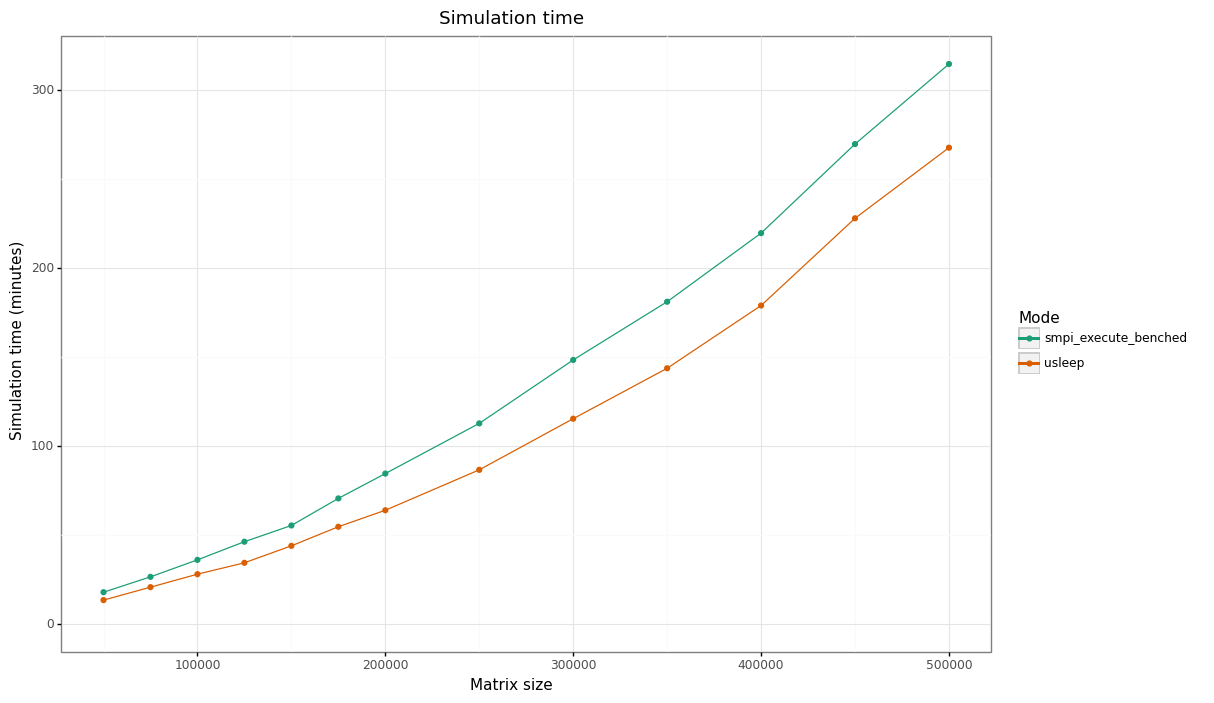

<ggplot: (8770882531855)>

In [6]:
import numpy

dfsim['simtime'] = dfsim['simulation_time'] / 60
(ggplot(dfsim)
    + aes(x='matrix_size', y='simtime', color='kind')
    + theme_bw()
    + expand_limits(y=0)
    + geom_point()
    + geom_line()
    + scale_color_brewer(type='qual', palette='Dark2')
    + xlab('Matrix size')
    + ylab('Simulation time (minutes)')
    + labs(color='Mode')
    + ggtitle('Simulation time')
)

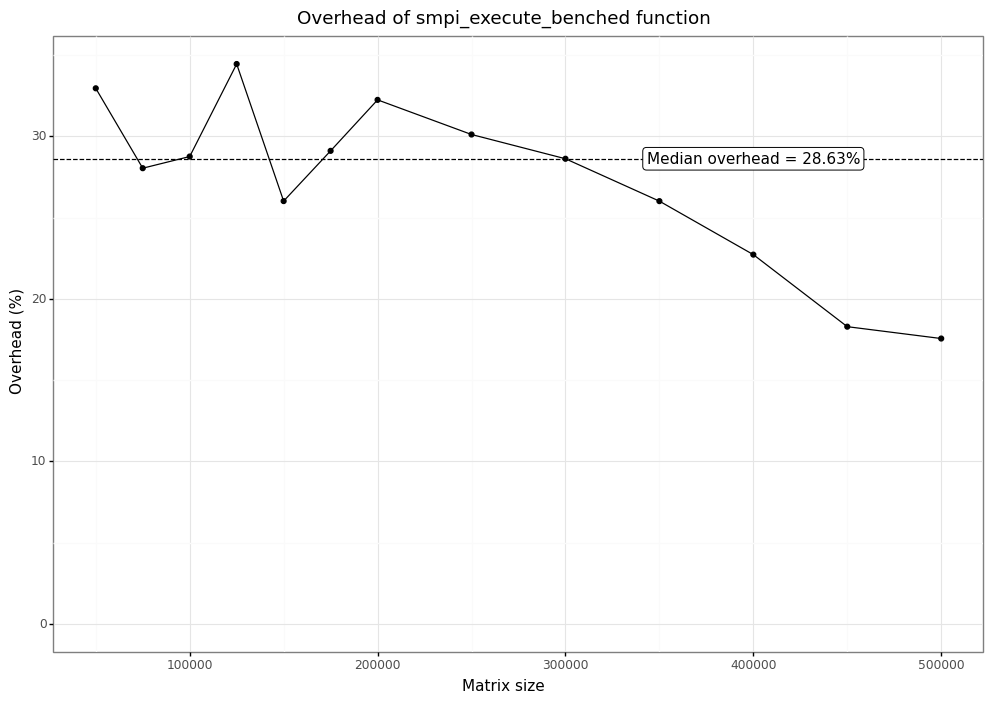

<ggplot: (8770882507335)>

In [7]:
a = dfsim[dfsim['kind'] != 'usleep'].set_index('matrix_size')
b = dfsim[dfsim['kind'] == 'usleep'].set_index('matrix_size')
a['ratio'] = (a['simulation_time'] / b['simulation_time'] - 1) * 100
a=a.reset_index()
median_ovh = a['ratio'].median()
(ggplot(a)
    + aes(x='matrix_size', y='ratio')
    + theme_bw()
    + expand_limits(y=0)
    + geom_point()
    + geom_line()
    + geom_hline(yintercept=median_ovh, linetype='dashed')
    + annotate('label', label=f'Median overhead = {median_ovh:.2f}%', x=400000, y=median_ovh)
    + scale_color_brewer(type='qual', palette='Dark2')
    + xlab('Matrix size')
    + ylab('Overhead (%)')
    + labs(color='Mode')
    + ggtitle('Overhead of smpi_execute_benched function')
)